In [1]:
import os

In [2]:
from scipy.stats import spearmanr, pearsonr, gaussian_kde
import numpy as np
import pandas as pd

In [3]:
from glob import glob
from matplotlib import pyplot as plt

In [4]:
import sqlite3 as lite 

# Load compartments

In [5]:
times = ['0h', '1h', '4h', '7h', '10h', '24h', 'w24h']
reps = ['1', '2']

In [6]:
db_path = '../../data/ComplementaryData/HiC/TADbit_results/'

In [7]:
ev_indexes = [1, 2]

In [8]:
hashs = {}
wjobids = {}
samples = []
for time in times:
    for rep in reps:

        sample = time, rep
        try:
            con = lite.connect(os.path.join(
                db_path, f'Cabrera_2022_HCT116_WT_NUT_{time}_TR{rep}/trace.db'))
        except lite.OperationalError:
            print(f'Error {sample}')
            continue
        print(os.path.join(
                db_path, f'Cabrera_2022_HCT116_WT_NUT_{time}_TR{rep}/trace.db'))
        hashs[sample] = {}
        wjobids[sample] = {}
        samples.append(sample)
        cur = con.cursor()
        cur.execute("""
        select distinct Id, Parameters, Parameters_md5 from JOBs
        where Type = 'Segment' AND parameters like '%compartments:1%' AND not parameters like '%crms:[chrY]%'
        """)
        jobids = cur.fetchall()
        for ev_index in ev_indexes:
            if ev_index == 1:
                test_ev = lambda x: 'ev_index:[2]' not in x
            else:
                test_ev = lambda x: 'ev_index:[2]' in x
            hashs[sample][ev_index] = {}
            wjobids[sample][ev_index] = {}
            for jobid, parameters, md5 in jobids:
                if test_ev(parameters):
                    c = parameters.split('crms:[')[1].split(']')[0]
                    hashs[sample][ev_index][c] = md5
                    wjobids[sample][ev_index][c] = jobid
        con.close()
        con = lite.connect(os.path.join(
            db_path, f'Cabrera_2022_HCT116_WT_NUT_{time}_TR{rep}/trace.db'))
        cur = con.cursor()
        cur.execute("""
        select distinct JOBid, richA_corr from SEGMENT_OUTPUTs where Resolution = 100000
        """)
        jobids = dict(cur.fetchall())
        for ev_index in ev_indexes:
            for c in wjobids[sample][ev_index]:
                wjobids[sample][ev_index][c] = abs(
                    jobids[wjobids[sample][ev_index][c]])
        con.close()


/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_0h_TR1/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_0h_TR2/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_1h_TR1/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_1h_TR2/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_4h_TR1/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_4h_TR2/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_7h_TR1/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_7h_TR2/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_10h_TR1/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_10h_TR2/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_reps/Cabrera_2022_HCT116_WT_NUT_24h_TR1/trace.db
/home/fransua/Projects/Monica_p53/Hi-C_r

check number of chromosomes loaded per sample:

In [9]:
for t in hashs:
    for e in ev_indexes:
        print('{}\t{}\t{}'.format(t, e, len(hashs[t][e])))

('0h', '1')	1	23
('0h', '1')	2	23
('0h', '2')	1	23
('0h', '2')	2	23
('1h', '1')	1	23
('1h', '1')	2	23
('1h', '2')	1	23
('1h', '2')	2	23
('4h', '1')	1	23
('4h', '1')	2	23
('4h', '2')	1	23
('4h', '2')	2	23
('7h', '1')	1	23
('7h', '1')	2	23
('7h', '2')	1	23
('7h', '2')	2	23
('10h', '1')	1	23
('10h', '1')	2	23
('10h', '2')	1	23
('10h', '2')	2	23
('24h', '1')	1	23
('24h', '1')	2	23
('24h', '2')	1	23
('24h', '2')	2	23
('w24h', '1')	1	23
('w24h', '1')	2	23
('w24h', '2')	1	23
('w24h', '2')	2	23
('w48h', '1')	1	23
('w48h', '1')	2	23
('w48h', '2')	1	23
('w48h', '2')	2	23


In [10]:
cpath = os.path.join(
    db_path, 
    'Cabrera_2022_HCT116_WT_NUT_{}_TR{}/06_segmentation/compartments_100kb/{}_EigVect{}_{}.tsv')

In [11]:
chromosomes = [f'chr{c}' for c in list(range(1, 23)) + ['X']]

In [12]:
h = 'hash'
evs = {}
for params in hashs:
    evs[params] = {}
    for nev in ev_indexes:
        evs[params][nev] = {}
        for c in chromosomes:
            evs[params][nev][c] = {}
            try:
                fh = open(cpath.format(*params, c, nev, hashs[params][nev][c]))
            except KeyError:
                print('MISSING:', params, nev, c)
                continue
            next(fh)
            for nl, line in enumerate(fh):
                ev = line.split('\t')[nev - 1]
                evs[params][nev][c][nl] = float(ev)

## Find best correlation between replicates

In [13]:
def nan_pearsonr(x, y):
    return pearsonr(*list(zip(*[(i, j) for i, j in zip(x, y) if np.isfinite(i) and np.isfinite(j)])))

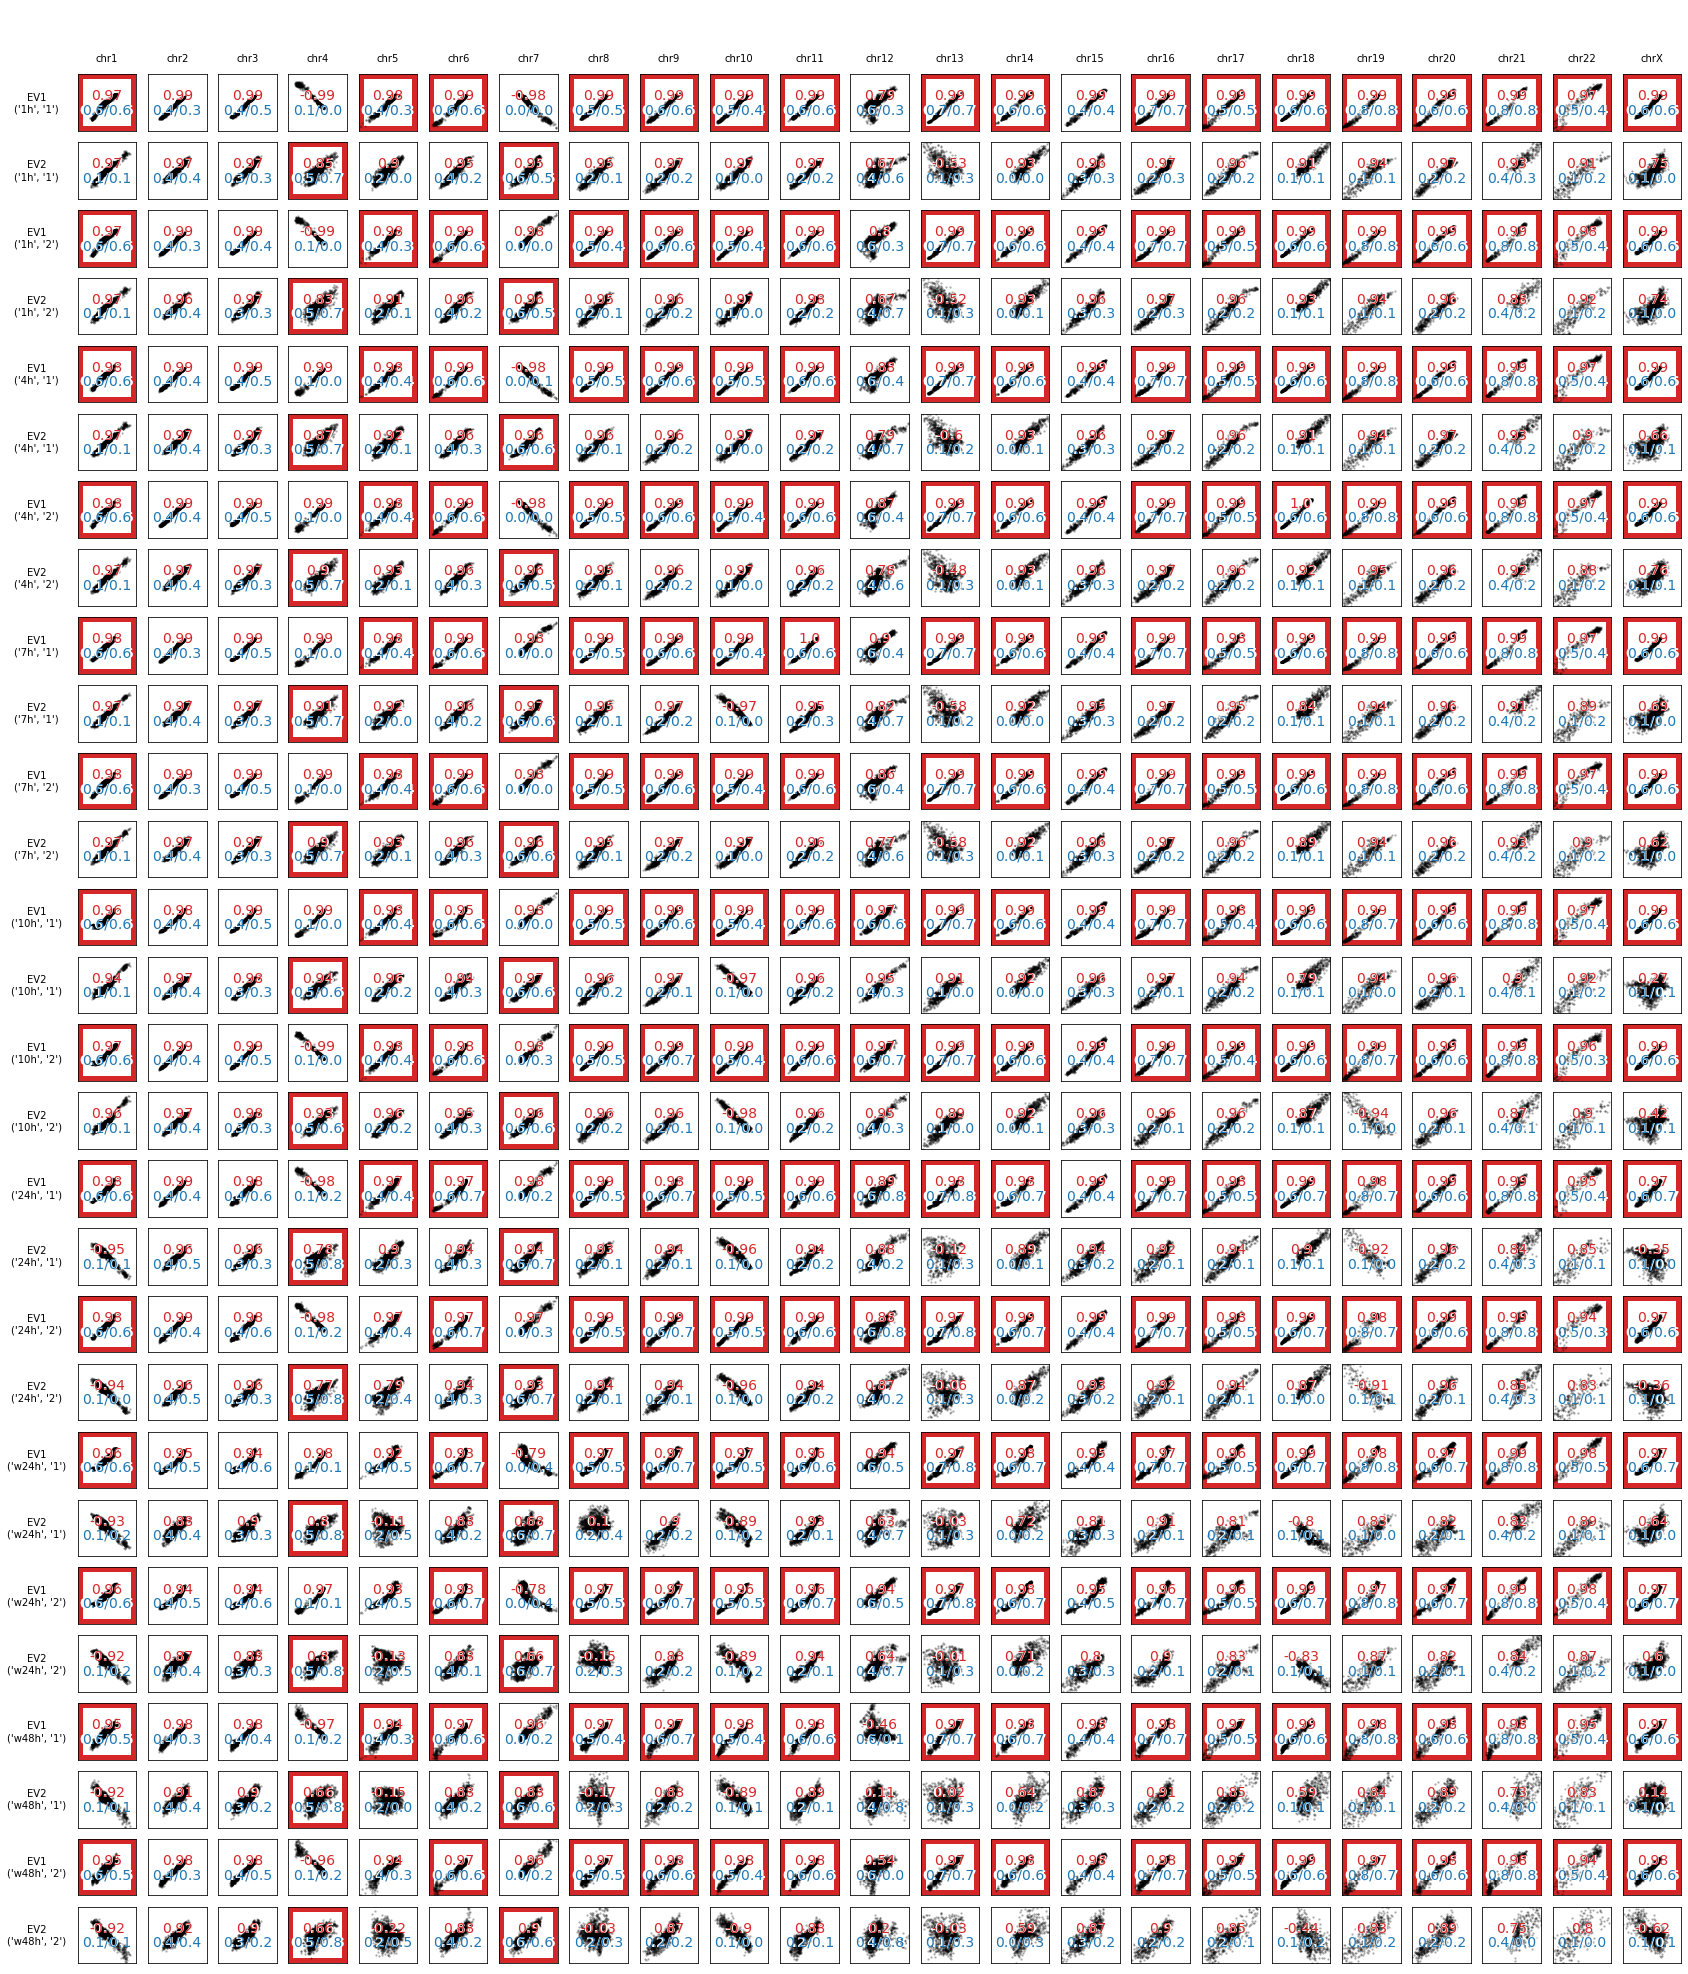

In [14]:
plt.figure(figsize=(30, 36))
nplot = 2
for c in chromosomes:
    plt.subplot(29, 24, nplot)
    plt.text(0, 0, c, va='center', ha='center')
    plt.xlim(-1, 1)
    plt.ylim(-.1, 1)
    plt.axis('off')
    nplot += 1
s1 = ('0h', '1')
for s2 in [('1h'  , '1'), ('1h'  , '2'), ('4h'  , '1'), ('4h'  , '2'), ('7h' , '1'), ('7h' , '2'),
           ('10h' , '1'), ('10h' , '2'), ('24h' , '1'), ('24h' , '2'), 
           ('w24h', '1'), ('w24h', '2'), ('w48h', '1'), ('w48h', '2')]:
    for e in ev_indexes:
        plt.subplot(29, 24, nplot)
        plt.text(0, 0, f'EV{e}\n{s2}', va='center', ha='center')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.axis('off')
        nplot += 1
        for c in chromosomes:
            x = list(evs[s1][e][c].values())
            y = list(evs[s2][e][c].values())
            if not x or not y:
                x = y = [0, 0]
            if len(x) != len(y):
                if len(x) < len(y):
                    x.extend([float('nan')] * (len(y) - len(x)))
                else:
                    y.extend([float('nan')] * (len(x) - len(y)))
            R, pv = nan_pearsonr(x, y)
            C1 = wjobids[s1][e][c]
            C2 = wjobids[s2][e][c]
            plt.subplot(29, 24, nplot)

            otherC1 = wjobids[s1][1 if e == 2 else 2][c]
            otherC2 = wjobids[s2][1 if e == 2 else 2][c]
            if C1 > otherC1 * 1.3 and C2 > otherC2 * 1.3:
                plt.plot([-0.1, -0.1, 0.1, 0.1, -0.1], [-0.1, 0.1, 0.1, -0.1, -0.1], lw=10, color='tab:red')

            nplot += 1
            plt.plot(x, y, 'k.', alpha=0.2, ms=3)
            plt.text(0, 0, round(R, 2), color='white', 
                     size=14, va='bottom', ha='center', weight='bold')
            plt.text(0, 0, round(R, 2), color='tab:red', 
                     size=14, va='bottom', ha='center')
            plt.text(0, 0, '{:.1f}/{:.1f}'.format(C1, C2), color='white', 
                     size=14, va='top', ha='center', weight='bold')
            plt.text(0, 0, '{:.1f}/{:.1f}'.format(C1, C2), color='tab:blue',
                     size=14, va='top', ha='center')
            plt.xticks([])
            plt.yticks([])
            plt.xlim(-.1, .1)
            plt.ylim(-.1, .1)


In [16]:
which_ev = {
    ('0h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('0h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('1h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('1h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('4h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('4h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('7h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('7h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('10h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('10h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('24h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('24h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('w24h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('w24h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('w48h', '1'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 2,  # manual inspection
    },
    ('w48h', '2'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 2,  # manual inspection
    }
}